# Fandango: Still Inflating Ratings?
-------
On 15th October 2015, a data journalist and INSIDER's Senior Editor for Data Walt Hickey published Be Suspicious Of Online Movie Ratings, Especially Fandango’s. You can find the article [Here.](https://fivethirtyeight.com/features/fandango-movies-ratings/)
He analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest.Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars. Hickey analyzed 8% of the rating data and found that:

1. The actual rating was almost always rounded up to the nearest half-star. 
2. In some cases, ratings rounding up to the nearest whole star. 
3. Most of the ratings were above 2 stars.

In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

# Introduction to the Data

We'll work with two samples of movie ratings:the data in one sample was collected previous to Hickey's analysis, while the other sample was collected after. Let's start by reading in the two samples (which are stored as CSV files) and getting familiar with their structure.

In [1]:
import pandas as pd
pd.options.display.max_columns = 100

previous = pd.read_csv('fandango_score_comparison.csv')

after = pd.read_csv('movie_ratings_16_17.csv')

previous.head(3)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,Metacritic_norm,Metacritic_user_nom,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,3.30,3.55,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,3.35,3.75,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,3.20,4.05,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5


In [2]:
after.head(5)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


Isolate the columns that offer information about Fandango's ratings in separate variables so we have just the data we're interested in more readily available for later use

We will make copies of data to avoid *SettingwithCopyWarning*

In [6]:
fandango_previous = previous[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes',
                             'Fandango_Difference']].copy()
fandango_after = after[['movie', 'year', 'fandango']].copy()

fandango_previous.head(5)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [7]:
fandango_after.head(5)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


Our goal is to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

From Hickey's article and from the [README.md](https://github.com/fivethirtyeight/data/blob/master/fandango/README.md) of the data set's repository, we can see that he used the following sampling criteria:

- The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
- The movie must have had tickets on sale in 2015.

Random sampling is not the option here because some movies didn't have a chance at all (like those having under 30 fan ratings or those without tickets on sale in 2015). It's questionable whether this sample is representative of the entire population we're interested to describe. It seems more likely that it isn't, mostly because this sample is subject to temporal trends — e.g. movies in 2015 might have been outstandingly good or bad compared to other years.

The sampling conditions for our other sample were (as it can be read in the [README.md](https://github.com/mircealex/Movie_ratings_2016_17/blob/master/README.md):

- The movie must have been released in 2016 or later.
- The movie must have had a considerable number of votes and reviews (unclear how many from the README.md or from the data).

This second sample is also subject to temporal trends and it's unlikely to be representative of our population of interest.

Both these authors had certain research questions in mind when they sampled the data, and they used a set of criteria to get a sample that would fit their questions. Their sampling method is called purposive sampling (or judgmental/selective/subjective sampling). 
While these samples were good enough for their research, they don't seem too useful for us.

# Revise the Goal of Analysis
-----
At this point, we can either collect new data or change our the goal of our analysis. We choose the latter and place some limitations on our initial goal.

Instead of trying to determine whether there has been any change in Fandango's rating system after Hickey's analysis, **our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016.** This new goal should also be a fairly good proxy for our initial goal.

# Criteria for Samples
With this new research goal, we have two populations of interest:

- All Fandango's ratings for popular movies released in 2015.
- All Fandango's ratings for popular movies released in 2016.

A movie is ***Popular*** only if it has 30 fan ratings or more on Fandango's website.


In [9]:

fandango_after.sample(10, random_state= 1)

# Here value "1" it suggests that we weren't trying out 
# various random seeds just to get a favorable sample.



,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


In [10]:
fandango_previous['Fandango_votes'] < 30

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
116    False
117    False
118    False
119    False
120    False
121    False
122    False
123    False
124    False
125    False
126    False
127    False
128    False
129    False
130    False
131    False
132    False
133    False
134    False
135    False
136    False
137    False
138    False
139    False
140    False
141    False
142    False
143    False
144    False
145    False
Name: Fandango_votes, Length: 146, dtype: bool

Let's also double-check the *fandango_previous* data set for popular movies. 
The documentation states clearly that there're only movies with at least 30 fan ratings. 

In [11]:

sum(fandango_previous['Fandango_votes'] < 30)

0

Here the value "0" suggests that there is no movie in data set with *fan rating* less than 30

In [12]:
fandango_previous.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [13]:
fandango_previous['FILM']

0                      Avengers: Age of Ultron (2015)
1                                   Cinderella (2015)
2                                      Ant-Man (2015)
3                              Do You Believe? (2015)
4                       Hot Tub Time Machine 2 (2015)
5                            The Water Diviner (2015)
6                               Irrational Man (2015)
7                                     Top Five (2014)
8                        Shaun the Sheep Movie (2015)
9                                 Love & Mercy (2015)
10                  Far From The Madding Crowd (2015)
11                                   Black Sea (2015)
12                                   Leviathan (2014)
13                                    Unbroken (2014)
14                          The Imitation Game (2014)
15                                     Taken 3 (2015)
16                                       Ted 2 (2015)
17                                    Southpaw (2015)
18     Night at the Museum: 

As per new goal, we are interested in movies released in 2015 - 2016.
Here we can see that *fandango_previous has movies other than 2015 - 2016.

Create a "Year" column to extract releasing year from "FILM".


In [14]:
fandango_previous["Year"]= fandango_previous["FILM"].str[-5:-1]

In [15]:
fandango_previous["Year"]

0      2015
1      2015
2      2015
3      2015
4      2015
5      2015
6      2015
7      2014
8      2015
9      2015
10     2015
11     2015
12     2014
13     2014
14     2014
15     2015
16     2015
17     2015
18     2014
19     2015
20     2015
21     2015
22     2015
23     2015
24     2015
25     2014
26     2015
27     2015
28     2014
29     2015
       ... 
116    2015
117    2015
118    2015
119    2015
120    2015
121    2015
122    2015
123    2015
124    2015
125    2015
126    2015
127    2015
128    2015
129    2015
130    2015
131    2015
132    2015
133    2015
134    2015
135    2015
136    2015
137    2015
138    2015
139    2015
140    2015
141    2015
142    2015
143    2014
144    2015
145    2015
Name: Year, Length: 146, dtype: object

In [16]:
fandango_previous.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,2015


In [17]:
fandango_previous["Year"].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

In [34]:
# create data set for the movies released in the year 2015
fandango_2015 = fandango_previous[fandango_previous['Year'] == '2015'].copy()


In [35]:
fandango_2015.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,2015


In [36]:
fandango_2015['Year'].value_counts()

2015    129
Name: Year, dtype: int64

Let's do the same to extract data for year 2016 from *fandango_after*

In [37]:
fandango_after.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


In [39]:
fandango_2016 = fandango_after[fandango_after['year'] == 2016].copy()
fandango_2016['year'].value_counts()



2016    191
Name: year, dtype: int64

# Distribution Shape for 2015 and 2016
-----
Analyze and compare the distributions of movie ratings for the two samples.

We'll start with comparing the shape of the two distributions using kernel density plots. We'll use the FiveThirtyEight style for the plots.

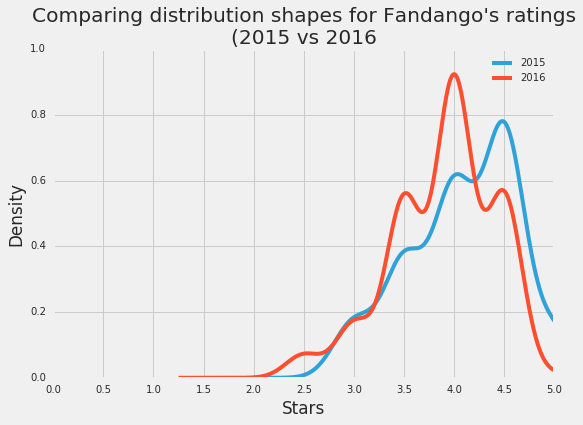

In [49]:
import matplotlib.pyplot as plt
from numpy import arange
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')

fandango_2015['Fandango_Stars'].plot.kde(label = '2015', legend = True, figsize = (8,5.5))
fandango_2016['fandango'].plot.kde(label = '2016', legend = True)

plt.title("Comparing distribution shapes for Fandango's ratings\n(2015 vs 2016")
plt.xlabel("Stars")
plt.xlim(0,5)
plt.xticks(arange(0,5.1,0.5))
plt.show()

Two aspects are striking on the figure above:

- Both distributions are strongly left skewed.
    - The left skew suggests that movies on Fandango are given mostly high and very high fan ratings. 
    - Coupled with the fact that Fandango sells tickets, the high ratings are a bit dubious
    
    
- The 2016 distribution is slightly shifted to the left relative to the 2015 distribution.
    - It shows that ratings were slightly lower in 2016 compared to 2015
    - This suggests that there was a difference indeed between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016.

# Frequancy Comaparison

In [54]:
fandango_2015['Fandango_Stars'].value_counts(normalize = True).sort_index() *100

3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [55]:
fandango_2016['fandango'].value_counts(normalize = True).sort_index() *100

2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

In 2016, very high ratings (4.5 and 5 stars) had significantly lower percentages compared to 2015. In 2016, under 1% of the movies had a perfect rating of 5 stars, compared to 2015 when the percentage was close to 7%. Ratings of 4.5 were also more popular in 2015 — there were approximately 13% more movies rated with a 4.5 in 2015 compared to 2016.

The minimum rating is also lower in 2016 — 2.5 instead of 3 stars, the minimum of 2015. There clearly is a difference between the two frequency distributions.

For some other ratings, the percentage went up in 2016. There was a greater percentage of movies in 2016 that received 3.5 and 4 stars, compared to 2015. 3.5 and 4.0 are high ratings and this challenges the direction of the change we saw on the kernel density plots.

# Determining the direction of the change

we'll compute the mean, the median, and the mode for both distributions and then use a bar graph to plot the values.

In [59]:
mean_2015 = fandango_2015['Fandango_Stars'].mean() 
mean_2016 = fandango_2016['fandango'].mean() 

median_2015 = fandango_2015['Fandango_Stars'].median() 
median_2016 = fandango_2016['fandango'].median()

mode_2015 = fandango_2015['Fandango_Stars'].mode()[0] 
mode_2016 = fandango_2016['fandango'].mode()[0]

summary= pd.DataFrame()

summary['2015']= [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ['mean', 'median', 'mode']
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


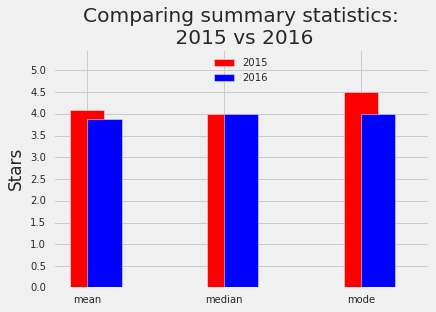

In [80]:
plt.style.use('fivethirtyeight')

summary['2015'].plot.bar(color = 'red', align = 'center', width= 0.25, label = '2015')
summary['2016'].plot.bar(color = 'blue',ani, align = 'edge',width= 0.25, label = '2016', rot = 0 )
plt.title('Comparing summary statistics:\n 2015 vs 2016')

plt.ylim(0,5.5)
plt.yticks(arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(framealpha = 0, loc = 'upper center')
plt.show()

# Conclusion
-----
Our analysis showed that there is:
- A slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. 
- On average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.

## Is there any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016?
---- 
Yes.

We cannot be completely sure what caused the change, but the chances are very high that it was caused by Fandango fixing the biased rating system after Hickey's analysis.